In [135]:
# Import dependencies
import pandas as pd
import requests
import numpy as np
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
import scipy.stats as st

from config import api_key

In [136]:
# Prepare the dataset for analysis
# Read in csv file
file_path = "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv"
inital_df = pd.read_csv(file_path)

# Drop the unwanted columns.
inital_df = inital_df.drop(columns=['Data As Of', 'Start Date', 'End Date', 'ICD10_codes', 'Number of Mentions', 'Flag'])

# Only keep the rows where the Group is "By Month", and delete the row where Age Group is "All Ages"
inital_df = inital_df.loc[inital_df['Group'] == 'By Month']
clean_df = inital_df.loc[inital_df['Age Group'] != 'All Ages']

# Drop the NaN values
clean_df = clean_df.dropna()

# Convert Year and Month columns to integers
clean_df.loc[:, 'Year'] = clean_df['Year'].astype(int)
clean_df.loc[:, 'Month'] = clean_df['Month'].astype(int)
clean_df.loc[:, 'COVID-19 Deaths'] = clean_df['COVID-19 Deaths'].astype(int)

clean_df.head()

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19


# Calculate the Correlation Between Public Transit and Death Rate for 2020

In [137]:
#DF 2020
year = 2020 
values_to_drop = ['United States', 'New York', 'Puerto Rico']
clean_df = clean_df.drop(clean_df[clean_df['State'].isin(values_to_drop)].index)
df_year = clean_df[clean_df['Year'] == year]
grouped = df_year.groupby('State')['COVID-19 Deaths'].sum()
df_grouped = pd.DataFrame({'State': grouped.index, 'COVID-19 Deaths': grouped.values})
df_grouped = df_grouped.sort_values('COVID-19 Deaths', ascending = False)

df_grouped.head()

,State,COVID-19 Deaths
4,California,135969
43,Texas,127240
9,Florida,85539
32,New York City,66448
30,New Jersey,64704


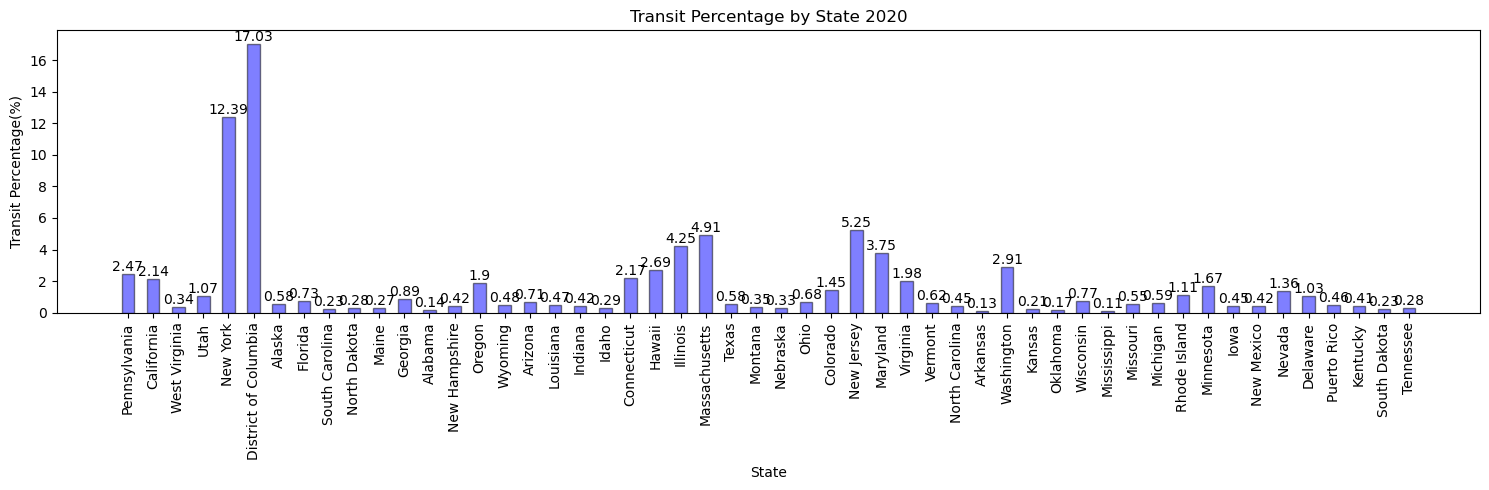

In [138]:
#fetch the population by state using Census API for 2020
c = Census(api_key, year=2020)
census_data_population = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})
census_data_population = pd.DataFrame(census_data_population)
#renme the columns
census_data_population = census_data_population.rename(columns={"B01003_001E": "Population", "NAME": "State"})
census_data_population.head()

#fetch the transit_public_transport by state using Census API for 2020, 2021, 2022, and 2023
c = Census(api_key, year=2020)
census_data_transit = c.acs5.get(("NAME", "B08301_010E"), {'for': 'state:*'})
census_data_transit = pd.DataFrame(census_data_transit)
#rename the columns
census_data_transit = census_data_transit.rename(columns={"B08301_010E": "Transit", "NAME": "State"})
census_data_transit.head()

# Merge the two dataframes on state
merged_df = pd.merge(census_data_population, census_data_transit, how = "right", on="State")

# Drop the unwanted columns.
merged_df = merged_df.drop(columns=['state_x', 'state_y'])
merged_df.head()

#calculate the transit percentage using transit/population
merged_df['Transit Percentage(%)'] = (merged_df['Transit']/merged_df['Population'])*100
merged_df.head()

#plot the transit percentage by State
plt.figure(figsize=(15, 5))
plt.bar(merged_df['State'], merged_df['Transit Percentage(%)'], color='b', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Transit Percentage by State 2020")
plt.xlabel("State")
plt.ylabel("Transit Percentage(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(merged_df['Transit Percentage(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Transit Percentage by State 2020.png")
plt.show()


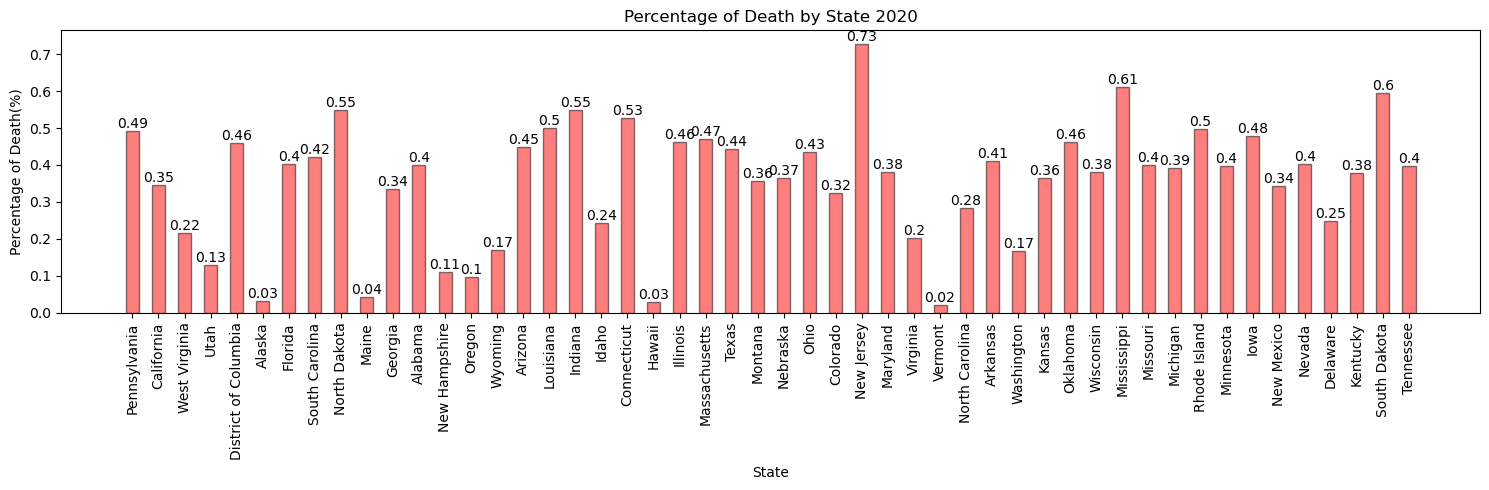

In [139]:
#merge the df_grouped and the census_data_population on state
percentage_death = pd.merge(df_grouped, census_data_population, how = "right", on="State")
percentage_death=percentage_death.drop(columns=['state'])
percentage_death.head()

#calculate the percentage of death using covid-19 deaths/population
percentage_death['Percentage of Death(%)'] = (percentage_death['COVID-19 Deaths']/percentage_death['Population'])*100
percentage_death=percentage_death.dropna()
percentage_death.head()

#plot the percentage of death by state
plt.figure(figsize=(15, 5))
plt.bar(percentage_death['State'], percentage_death['Percentage of Death(%)'], color='r', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Percentage of Death by State 2020")
plt.xlabel("State")
plt.ylabel("Percentage of Death(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(percentage_death['Percentage of Death(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Percentage of Death by State 2020.png")
plt.show()



In [140]:
#combine the transit percentage and the percentage of death into a new dataframe
transit_percentage_death = pd.merge(merged_df, percentage_death, how = "right", on="State")
transit_percentage_death=transit_percentage_death.drop(columns=['Population_y','Population_x','COVID-19 Deaths','Transit', 'COVID-19 Deaths'])
#drop the nan values
transit_percentage_death = transit_percentage_death.dropna()

The correlation between both factors is 0.14


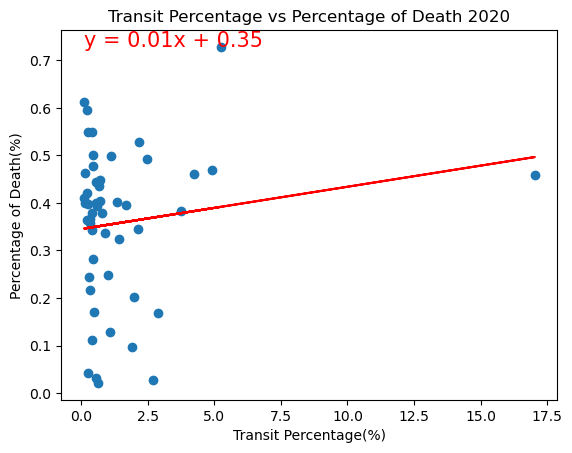

In [141]:


#establish the correlation between transit percentage and percentage of death
correlation = st.pearsonr(transit_percentage_death['Transit Percentage(%)'], transit_percentage_death['Percentage of Death(%)'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

#calulate the linear regression
x_values = transit_percentage_death['Transit Percentage(%)']
y_values = transit_percentage_death['Percentage of Death(%)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

#add the equation and line to plot
plt.annotate(line_eq, (min(x_values), max(y_values)), fontsize=15, color="red")
plt.title('Transit Percentage vs Percentage of Death 2020')
plt.xlabel('Transit Percentage(%)')
plt.ylabel('Percentage of Death(%)')
plt.savefig("figs/Transit Percentage vs Percentage of Death 2020.png")
plt.show()


# Calculate the Correlation Between Public Transit and Death Rate for 2021

In [142]:
#fetch the population by state using Census API for 2021
c = Census(api_key, year=2021)
census_data_population = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})
census_data_population = pd.DataFrame(census_data_population)
#renme the columns
census_data_population = census_data_population.rename(columns={"B01003_001E": "Population", "NAME": "State"})
census_data_population.head()


,State,Population,state
0,Alabama,4997675.0,01
1,Alaska,735951.0,02
2,Arizona,7079203.0,04
3,Arkansas,3006309.0,05
4,California,39455353.0,06


In [143]:
#fetch the transit_public_transport by state using Census API for 2021
c = Census(api_key, year=2021)
census_data_transit = c.acs5.get(("NAME", "B08301_010E"), {'for': 'state:*'})
census_data_transit = pd.DataFrame(census_data_transit)
#rename the columns
census_data_transit = census_data_transit.rename(columns={"B08301_010E": "Transit", "NAME": "State"})
census_data_transit.head()

,State,Transit,state
0,Alabama,7097.0,01
1,Alaska,4139.0,02
2,Arizona,44037.0,04
3,Arkansas,3748.0,05
4,California,743816.0,06


In [144]:

# Merge the two dataframes on state
merged_df = pd.merge(census_data_population, census_data_transit, how = "right", on="State")

# Drop the unwanted columns.
merged_df = merged_df.drop(columns=['state_x', 'state_y'])
merged_df.head()

,State,Population,Transit
0,Alabama,4997675.0,7097.0
1,Alaska,735951.0,4139.0
2,Arizona,7079203.0,44037.0
3,Arkansas,3006309.0,3748.0
4,California,39455353.0,743816.0


In [145]:
#calculate the transit percentage using transit/population
merged_df['Transit Percentage(%)'] = (merged_df['Transit']/merged_df['Population'])*100
merged_df.head()

,State,Population,Transit,Transit Percentage(%)
0,Alabama,4997675.0,7097.0,0.142006
1,Alaska,735951.0,4139.0,0.562402
2,Arizona,7079203.0,44037.0,0.622062
3,Arkansas,3006309.0,3748.0,0.124671
4,California,39455353.0,743816.0,1.885209


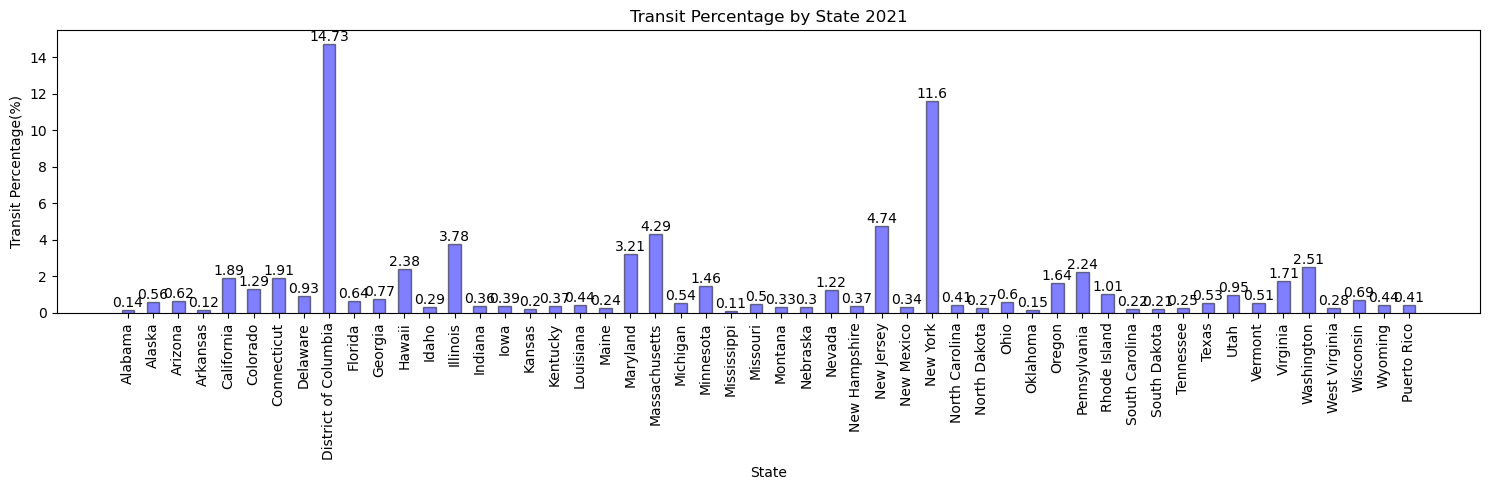

In [146]:
#plot the transit percentage by State
plt.figure(figsize=(15, 5))
plt.bar(merged_df['State'], merged_df['Transit Percentage(%)'], color='b', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Transit Percentage by State 2021")
plt.xlabel("State")
plt.ylabel("Transit Percentage(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(merged_df['Transit Percentage(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Transit Percentage by State 2021.png")
plt.show()

In [147]:
#DF 2021
year = 2021 
values_to_drop = ['United States', 'New York', 'Puerto Rico']
clean_df = clean_df.drop(clean_df[clean_df['State'].isin(values_to_drop)].index)
df_year_2 = clean_df[clean_df['Year'] == year]
grouped_2 = df_year_2.groupby('State')['COVID-19 Deaths'].sum()
df_grouped_2 = pd.DataFrame({'State': grouped_2.index, 'COVID-19 Deaths': grouped_2.values})
df_grouped_2 = df_grouped_2.sort_values('COVID-19 Deaths', ascending = False)

df_grouped_2.head()

,State,COVID-19 Deaths
4,California,202929
43,Texas,188130
9,Florida,145836
38,Pennsylvania,76078
35,Ohio,73934


In [148]:
#merge the df_grouped_2 and the census_data_population on state
percentage_death = pd.merge(df_grouped_2, census_data_population, how = "right", on="State")
percentage_death=percentage_death.drop(columns=['state'])
percentage_death.head()

#calculate the percentage of death using covid-19 deaths/population
percentage_death['Percentage of Death(%)'] = (percentage_death['COVID-19 Deaths']/percentage_death['Population'])*100

#drop the nan values
percentage_death = percentage_death.dropna()

percentage_death.head()

,State,COVID-19 Deaths,Population,Percentage of Death(%)
0,Alabama,29628.0,4997675.0,0.592836
1,Alaska,1259.0,735951.0,0.171071
2,Arizona,49638.0,7079203.0,0.701181
3,Arkansas,16886.0,3006309.0,0.561685
4,California,202929.0,39455353.0,0.514326


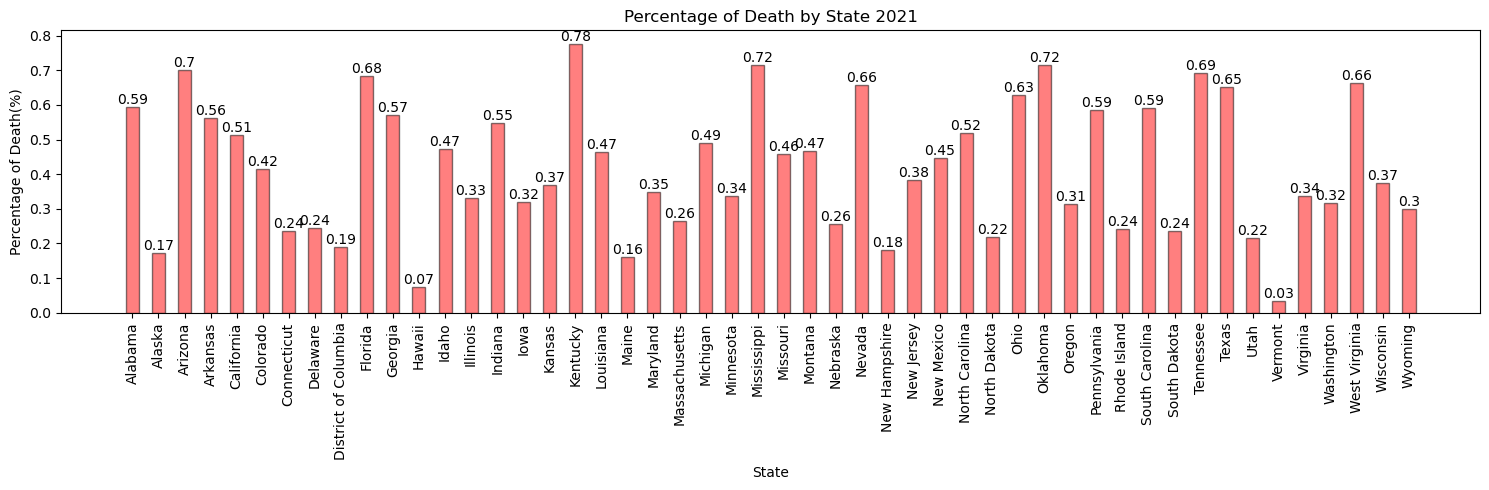

In [149]:
#plot the percentage of death by state
plt.figure(figsize=(15, 5))
plt.bar(percentage_death['State'], percentage_death['Percentage of Death(%)'], color='r', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Percentage of Death by State 2021")
plt.xlabel("State")
plt.ylabel("Percentage of Death(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(percentage_death['Percentage of Death(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Percentage of Death by State 2021.png")
plt.show()

In [150]:
#combine the transit percentage and the percentage of death into a new dataframe
transit_percentage_death = pd.merge(merged_df, percentage_death, how = "right", on="State")
transit_percentage_death=transit_percentage_death.drop(columns=['Population_y','Population_x','COVID-19 Deaths','Transit', 'COVID-19 Deaths'])
#drop the nan values
transit_percentage_death = transit_percentage_death.dropna()

transit_percentage_death.head()

,State,Transit Percentage(%),Percentage of Death(%)
0,Alabama,0.142006,0.592836
1,Alaska,0.562402,0.171071
2,Arizona,0.622062,0.701181
3,Arkansas,0.124671,0.561685
4,California,1.885209,0.514326


The correlation between both factors is -0.28


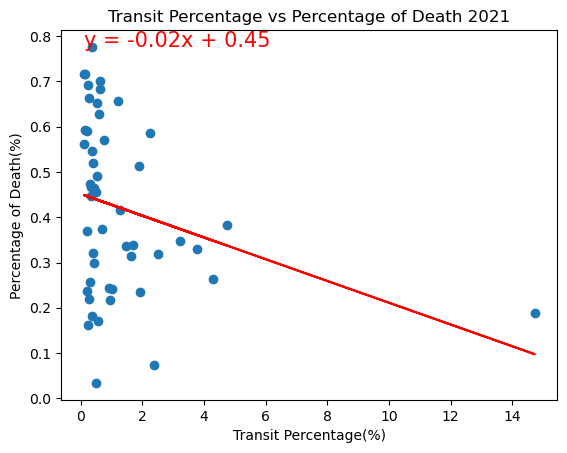

In [151]:
#establish the correlation between transit percentage and percentage of death
correlation = st.pearsonr(transit_percentage_death['Transit Percentage(%)'], transit_percentage_death['Percentage of Death(%)'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

#calulate the linear regression
x_values = transit_percentage_death['Transit Percentage(%)']
y_values = transit_percentage_death['Percentage of Death(%)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))



plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")


#add the equation and line to plot
plt.annotate(line_eq, (min(x_values), max(y_values)), fontsize=15, color="red")
plt.title('Transit Percentage vs Percentage of Death 2021')
plt.xlabel('Transit Percentage(%)')
plt.ylabel('Percentage of Death(%)')
plt.savefig("figs/Transit Percentage vs Percentage of Death 2021.png")
plt.show()